### Import external modules

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

### Add mbt-gym to path

In [2]:
import sys
sys.path.append("../")

In [3]:
from mbt_gym.agents.BaselineAgents import CarteaJaimungalAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import PnL, CjCriterion
from mbt_gym.stochastic_processes.midprice_models import *
from mbt_gym.stochastic_processes.fill_probability_models import *
from mbt_gym.stochastic_processes.arrival_models import *

### Create market making environment

In [4]:
terminal_time = 1.0
arrival_rate = 10.0
n_steps = int(10 * terminal_time * arrival_rate)
phi = 0.5
alpha = 0.001

In [5]:
def get_cj_env(num_trajectories:int = 1):    
    fill_exponent = 1
    sigma = 0.1
    initial_inventory = (-4,5)
    initial_price = 100
    step_size = 1/n_steps
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      midprice_model = BrownianMotionMidpriceModel(volatility=sigma, 
                                                                   terminal_time=terminal_time, 
                                                                   step_size=step_size, 
                                                                   initial_price=initial_price, 
                                                                   num_trajectories=num_trajectories),
                      arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate,arrival_rate]), 
                                                           step_size=step_size, 
                                                          num_trajectories=num_trajectories),
                      fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                                       step_size=step_size, 
                                                                       num_trajectories=num_trajectories),
                      reward_function = CjCriterion(phi, alpha),
                      max_inventory=n_steps,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [6]:
num_trajectories = 1000
env = ReduceStateSizeWrapper(get_cj_env(num_trajectories))
sb_env = StableBaselinesTradingEnvironment(trading_env=env)

In [7]:
# Monitor sb_env
sb_env = VecMonitor(sb_env)
# Add directory for tensorboard logging and best model
tensorboard_logdir = "./tensorboard/PPO-learning-CJ/"
best_model_path = "./SB_models/PPO-best-CJ"

### Define PPO policy

In [8]:
policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])])
PPO_params = {"policy":'MlpPolicy', "env": sb_env, "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "n_epochs":5,
              "batch_size": int(n_steps * num_trajectories / 10), 
              "n_steps": int(n_steps)}
callback_params = dict(eval_env=sb_env, n_eval_episodes = 2048, #200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)
model = PPO(**PPO_params, device="auto")

Using cuda device


In [9]:
model.learn(total_timesteps = 10_000_000)  # Increase number of training timesteps according to computing resources

Logging to ./tensorboard/PPO-learning-CJ/PPO_1
-----------------------------------
| rollout/           |            |
|    ep_len_mean     | 100        |
|    ep_rew_mean     | -5.4088554 |
| time/              |            |
|    fps             | 4946       |
|    iterations      | 1          |
|    time_elapsed    | 20         |
|    total_timesteps | 100000     |
-----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -5.505676    |
| time/                   |              |
|    fps                  | 9119         |
|    iterations           | 2            |
|    time_elapsed         | 21           |
|    total_timesteps      | 200000       |
| train/                  |              |
|    approx_kl            | 0.0034380234 |
|    clip_fraction        | 0.0176       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84 

## Comparing the learnt policy to the optimal policy

In [10]:
from mbt_gym.agents.SbAgent import SbAgent

In [11]:
ppo_agent = SbAgent(model)

In [12]:
inventories = np.arange(-3,4,1)
bid_actions = []
ask_actions = []
for inventory in inventories:
    bid_action, ask_action = ppo_agent.get_action(np.array([[inventory,0.5]]))
    bid_actions.append(bid_action)
    ask_actions.append(ask_action)    

In [13]:
cj_agent = CarteaJaimungalAgent(phi = phi, alpha= alpha, env=get_cj_env())

In [14]:
# Get the Cartea Jaimungal action
cj_bid_actions = []
cj_ask_actions = []
for inventory in inventories:
    bid_action, ask_action = cj_agent.get_action(np.array([[0,inventory,0.5]])).reshape(-1)
    cj_bid_actions.append(bid_action)
    cj_ask_actions.append(ask_action)

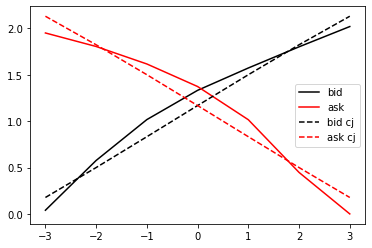

In [15]:
plt.plot(inventories, bid_actions, label = "bid", color = "k")
plt.plot(inventories, ask_actions, label = "ask", color = "r")
plt.plot(inventories, cj_bid_actions, label = "bid cj", color = "k", linestyle = "--")
plt.plot(inventories, cj_ask_actions, label = "ask cj", color = "r", linestyle = "--")
plt.legend()